In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['bmh'])
import statsmodels.api as sm
from scipy import stats
import os

# DATA Count  OTU

In [107]:
df1=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/binary-data_Yield_per_plant.csv")
df1=df1[['Link_ID','Yield_per_plant']]
df2 = pd.read_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/metadata.csv')
df2 = df2[['Unnamed: 0', 'Yield_per_plant']]
df2.rename(columns={'Unnamed: 0':'Link_ID','Yield_per_plant':'y_con'}, inplace=True)
df1.rename(columns={'Yield_per_plant':"y_binary"}, inplace=True)

response=pd.merge( df2, df1,on='Link_ID')

In [108]:
#response.index=response['Link_ID']
#response=response.drop(columns='Link_ID')

In [109]:
response

,Link_ID,y_con,y_binary
0,MN_10_1_Y1,1326.10000,1.0
1,MN_10_2_Y1,1202.60000,1.0
2,MN_10_3_Y1,745.70000,0.0
3,MN_11_1_Y1,1394.20000,1.0
4,MN_11_2_Y1,1174.50000,1.0
...,...,...,...
214,WI_8_1_Y1,1266.66667,0.0
215,WI_8_2_Y1,2188.66667,1.0
216,WI_8_3_Y1,1711.33333,1.0
217,WI_9_1_Y1,1511.00000,1.0


Text(0, 0.5, 'Sample Label')

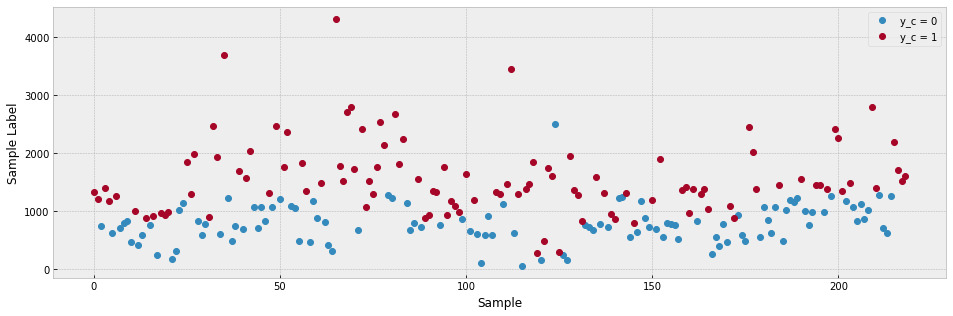

In [110]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')


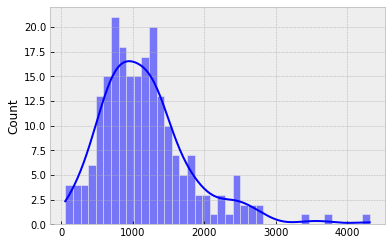

In [111]:
sns.histplot(response['y_con'].values,bins=40, kde=True)
plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/response.png',bbox_inches = 'tight',pad_inches=0,facecolor='white')

0.392782580186084


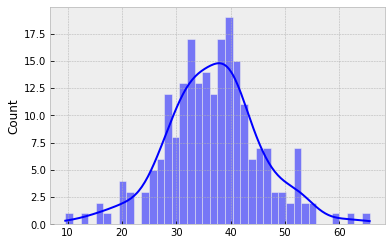

In [112]:
fitted_y, fitted_lambda = stats.boxcox(response['y_con'])
sns.histplot(fitted_y,bins=40, kde=True)
print(fitted_lambda)

In [113]:
response['y_boxcox'] = fitted_y

/Users/rosa/opt/anaconda3/envs/testEnv/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y_con', ylabel='y_boxcox'>

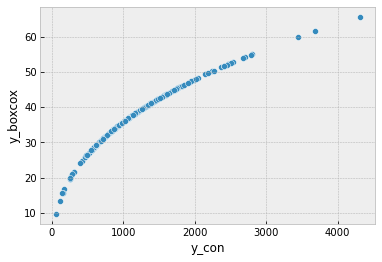

In [114]:
sns.scatterplot(response['y_con'], response['y_boxcox'])

# Data without NA

In [39]:
k=0
data_shape1=[]
data_shape2=[]
data_shape3=[]
qt=[]
q=0.3
os.chdir('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/Compiled_data')
path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/Compiled_data'

for file in os.listdir(path):
    if file[-4:] == '.csv':
        print(file)
        data_temp = pd.read_csv(file,header=0,index_col=0)
        data_temp = data_temp.rename(columns={data_temp.columns[0]:'Link_ID'})
        df1=data_temp.set_index('Link_ID').T
        df1=df1.reset_index()
        df1=df1.rename(columns={'index':'Link_ID'})
        data_shape1.append(df1.shape[1])
        data_original = pd.merge(df1, response, on='Link_ID')
        duplicated_columns_list = []
        list_of_all_columns = list(df1.columns)
        for column in list_of_all_columns:
            if list_of_all_columns.count(column) > 1 and not column in duplicated_columns_list:
                duplicated_columns_list.append(column)
        data_original=data_original.drop(columns=duplicated_columns_list)
        data_shape2.append(data_original.shape[1])
        print(data_original.shape[1])
        nsample_OTU=[]
        for col in data_original.drop(columns=response.columns).columns:
            I = data_original[col]>0
            nsample_OTU.append(sum(I))
            
        fr_OTU=pd.DataFrame()
        fr_OTU['OTU'] = data_original.drop(columns=response.columns).columns
        fr_OTU['Fr']  = pd.DataFrame(nsample_OTU)
        fr_OTU['value OTU']=data_original.drop(columns=response.columns).sum(0).values
        fr_OTU=fr_OTU.set_index('OTU')
        fr_OTU=fr_OTU.sort_values('Fr',ascending=False)
        fr_OTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/frequency_OTU'+file)
        qtt=np.quantile(fr_OTU['Fr'],q)
        qt.append(qtt)
        th=max(15,qtt)
        remain_col=fr_OTU[fr_OTU['Fr']>th].index
        remain_col=remain_col.insert(0, 'Link_ID')
        CountOTU=data_original[remain_col]
        CountOTU=CountOTU.set_index('Link_ID')
        CountOTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data/CountOTU'+file)
        data_shape3.append(CountOTU.shape[1])
        
        

Y1_F_Genus.csv
1326
Y1_F_Family.csv
483
Y1_F_Phylum.csv
64
Y1_F_Class.csv
159
Y1_F_Order.csv
385


In [40]:
list_name=['Y1_F_Genus','Y1_F_Family','Y1_F_Phylum','Y1_F_Class','Y1_F_Order']
df_report=pd.DataFrame()
df_report.index=list_name
df_report['number of OTU with NA']=data_shape1
df_report['number of OTU']=data_shape2
df_report['quantile']=qt
df_report['number of OTU filter']=data_shape3
df_report.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/df_report.csv')

$\color{red}{\text{Among 219 sample I consider otu with frequency >15. 
If these 15 sample has large values is it imoportant to consider them or not???}}$

In [41]:
df_report

,number of OTU with NA,number of OTU,quantile,number of OTU filter
Y1_F_Genus,2018,1326,1.0,485
Y1_F_Family,856,483,4.0,255
Y1_F_Phylum,64,64,19.7,42
Y1_F_Class,196,159,17.4,108
Y1_F_Order,511,385,6.0,224


In [100]:
#=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data_Y_per_Yield/response.csv")
#response.rename(columns={'Yield_per_plant':"y_con"}, inplace=True)
#response = response.set_index('Link_ID')
#df1=df1[['Link_ID','Yield_per_plant']]
#df2 = pd.read_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/metadata.csv')
#df2 = df2[['Unnamed: 0', 'Yield_per_plant']]
#df2.rename(columns={'Unnamed: 0':'Link_ID','Yield_per_plant':'y_con'}, inplace=True)
#df1.rename(columns={'Yield_per_plant':"y_binary"}, inplace=True)

#response=pd.merge(df1, df2, on='Link_ID')

# Yield_per_meter Response


In [9]:
#Yield_per_meter
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/yield_per_meter.csv")
response=response.drop(columns='Variety2')
response.rename(columns={'Column1':'Link_ID','Yield_per_meter':'y_con','x1':'y_binary'}, inplace=True)


In [10]:
response

,Link_ID,y_con,y_binary
0,MN_10_1_Y1,5220.8557,1.0
1,MN_10_2_Y1,4734.6362,1.0
2,MN_10_3_Y1,2935.8209,0.0
3,MN_11_1_Y1,5488.9654,1.0
4,MN_11_2_Y1,4624.0065,1.0
...,...,...,...
191,WI_8_1_Y1,3800.0000,1.0
192,WI_8_2_Y1,6566.0000,1.0
193,WI_8_3_Y1,5134.0000,1.0
194,WI_9_1_Y1,4533.0000,1.0


Text(0, 0.5, 'Sample Label')

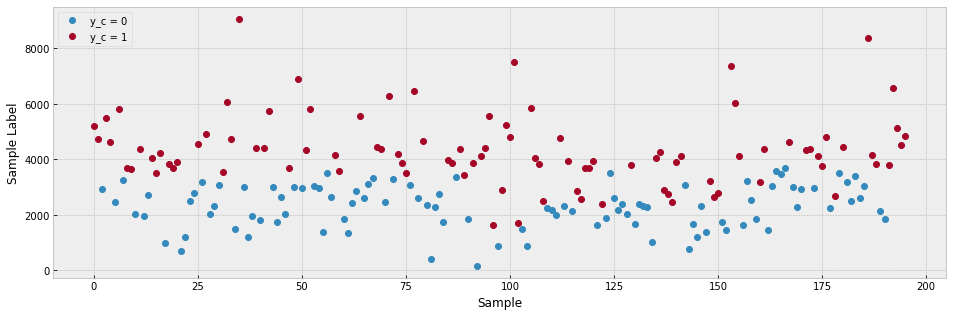

In [74]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')


In [75]:
response['y_con'].loc[response['y_binary']==0]

2      2935.8209
5      2461.4124
7      3263.5414
10     2044.1779
12     1954.1415
         ...    
183    3387.5000
184    2607.9400
185    3052.5000
189    2141.5000
190    1846.5000
Name: y_con, Length: 100, dtype: float64

# scab_severity response

In [76]:
#scab_severity response
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/scab_severity.csv")
response=response.drop(columns='Variety2')
response.rename(columns={'Column1':'Link_ID','Scab_severity':'y_con','x1':'y_binary'}, inplace=True)
response

,Link_ID,y_con,y_binary
0,MN_10_1_Y1,51.416667,1.0
1,MN_10_2_Y1,44.000000,1.0
2,MN_10_3_Y1,108.400000,1.0
3,MN_11_1_Y1,92.866667,1.0
4,MN_11_2_Y1,90.823529,1.0
...,...,...,...
226,WI_8_1_Y1,0.000000,0.0
227,WI_8_2_Y1,0.117647,0.0
228,WI_8_3_Y1,32.727273,1.0
229,WI_9_1_Y1,0.000000,0.0


Text(0, 0.5, 'Sample Label')

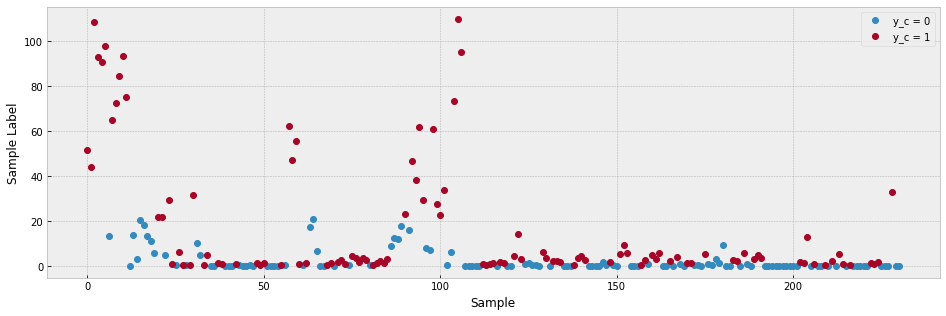

In [77]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')

# no_tuber_scab

In [78]:
#scab_severity response
response=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/no_tuber_scab.csv")
response=response.drop(columns='Variety2')
response.rename(columns={'Column1':'Link_ID','No_tuber_scab':'y_con','x1':'y_binary'}, inplace=True)
response

,Link_ID,y_con,y_binary
0,MN_10_1_Y1,12.0,1.0
1,MN_10_2_Y1,8.0,0.0
2,MN_10_3_Y1,10.0,1.0
3,MN_11_1_Y1,15.0,1.0
4,MN_11_2_Y1,17.0,1.0
...,...,...,...
226,WI_8_1_Y1,0.0,0.0
227,WI_8_2_Y1,2.0,1.0
228,WI_8_3_Y1,8.0,1.0
229,WI_9_1_Y1,0.0,0.0


Text(0, 0.5, 'Sample Label')

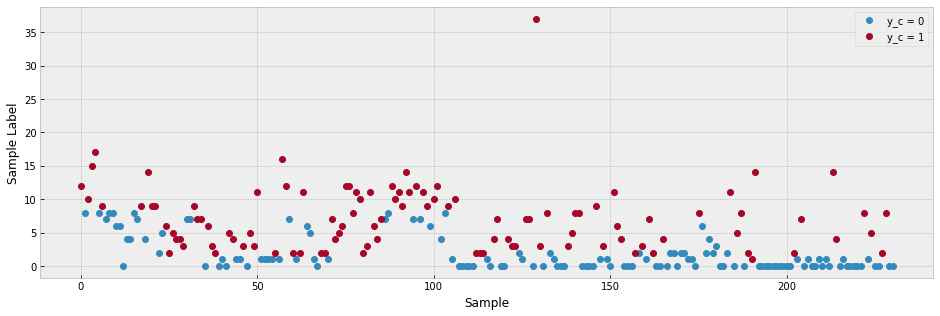

In [79]:
plt.figure(figsize=(16,5))
plt.plot(response['y_con'].loc[response['y_binary']==0],'o')
plt.plot(response['y_con'].loc[response['y_binary']==1],'o')
plt.legend(['y_c = 0', 'y_c = 1'])
plt.xlabel('Sample')
plt.ylabel('Sample Label')

# Data_With_NA

In [151]:
os.listdir(path)

['.DS_Store',
 'Y1_F_Genus.csv',
 'df1.csv',
 'Y1_F_Family.csv',
 'Y1_F_Phylum.csv',
 'Y1_F_Class.csv',
 'Y1_F_Order.csv']

In [8]:
df1.drop(columns='Link_ID').columns

Index([              'Pseudarthrobacter',                  'Bradyrhizobium',
                                'Afipia',                        'Bacillus',
                          'Sphingomonas',                               nan,
          'Clostridium sensu stricto 13',                     'Terrabacter',
                 'Candidatus Koribacter',                               nan,
       ...
                        'Deinobacterium',                               nan,
                       'Cloacibacterium',                      'Anaerobium',
                                     nan, '[Rhizobium] sphaerophysae group',
                       'Xylanibacterium',                  'Frondihabitans',
                            'Cnuibacter',                    'Dechlorosoma'],
      dtype='object', name='Link_ID', length=2017)

In [11]:
k=0
data_shape1=[]
data_shape2=[]
data_shape3=[]
qt=[]
q=0.3
os.chdir('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/Compiled_data')
path = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/Compiled_data'

for file in os.listdir(path):
    if (file[-4:] == '.csv')&(file[0] != 'd'):
        print(file)
        data_temp = pd.read_csv(file,header=0,index_col=0)
        data_temp = data_temp.rename(columns={data_temp.columns[0]:'Link_ID'})
        df1=data_temp.set_index('Link_ID').T
        df1=df1.reset_index()
        df1=df1.rename(columns={'index':'Link_ID'})
        data_shape1.append(df1.shape[1])
        data_original = pd.merge(df1, response, on='Link_ID')
        data_original.to_csv('df1.csv')
        data_original=pd.read_csv('df1.csv')
        data_shape2.append(data_original.shape[1])
        print(data_original.shape[1])
        nsample_OTU=[]
        for col in data_original.drop(columns=response.columns).columns:
            I = data_original[col]>0
            nsample_OTU.append(sum(I))
            
        fr_OTU=pd.DataFrame()
        fr_OTU['OTU'] = data_original.drop(columns=response.columns).columns
        fr_OTU['Fr']  = pd.DataFrame(nsample_OTU)
        fr_OTU['value OTU']=data_original.drop(columns=response.columns).sum(0).values
        fr_OTU=fr_OTU.set_index('OTU')
        fr_OTU=fr_OTU.sort_values('Fr',ascending=False)
        fr_OTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/frequency_OTU'+file)
        qtt=np.quantile(fr_OTU['Fr'],q)
        qt.append(qtt)
        th=max(15,qtt)
        remain_col=fr_OTU[fr_OTU['Fr']>th].index
        remain_col=remain_col.insert(0, 'Link_ID')
        CountOTU=data_original[remain_col]
        CountOTU=CountOTU.set_index('Link_ID')
        CountOTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data/withNA/CountOTU'+file)
        data_shape3.append(CountOTU.shape[1])
        
        

Y1_F_Genus.csv
2021
Y1_F_Family.csv
859
Y1_F_Phylum.csv
67
Y1_F_Class.csv
199
Y1_F_Order.csv
514


In [12]:
list_name=['Y1_F_Genus','Y1_F_Family','Y1_F_Phylum','Y1_F_Class','Y1_F_Order']
df_report=pd.DataFrame()
df_report.index=list_name
df_report['number of OTU with NA']=data_shape1
df_report['quantile']=qt
df_report['number of OTU filter']=data_shape3
df_report.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/df_report_withNA.csv')

In [13]:
df_report

,number of OTU with NA,quantile,number of OTU filter
Y1_F_Genus,2018,2.0,824
Y1_F_Family,856,4.0,457
Y1_F_Phylum,64,21.9,45
Y1_F_Class,196,11.5,134
Y1_F_Order,511,6.0,302


In [148]:
data_original.columns

Index(['Unnamed: 0', 'Link_ID', 'Micrococcales', 'Rhizobiales', 'Bacillales',
       'Sphingomonadales', 'Clostridiales', 'Acidobacteriales',
       'Microtrichales', 'Frankiales',
       ...
       'Unnamed: 505', 'Unnamed: 506', 'I3A', 'Pseudanabaenales',
       'Thermovenabulales', 'Thermosynechococcales', 'Unnamed: 511', 'y_con',
       'y_binary', 'y_boxcox'],
      dtype='object', length=515)

# Report Phylum

In [12]:
df1=pd.read_csv("/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/binary-data.csv")
df2 = pd.read_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/metadata.csv')
df1=df1.drop('Variety2',axis=1)
df1.rename(columns={'Yield_per_plant':"y_binary"}, inplace=True)
df2 = df2[['Unnamed: 0', 'Yield_per_plant']]
df2.rename(columns={'Unnamed: 0':'Link_ID'}, inplace=True)
data_original = pd.merge(df1, df2, on='Link_ID')

In [13]:
print(df1.shape)
print(df2.shape)
print(data_original.shape)

(219, 65)
(257, 2)
(219, 66)


In [14]:
data_original.head()

,Link_ID,Actinobacteriota,Proteobacteria,Firmicutes,Acidobacteriota,Chloroflexi,Gemmatimonadota,Verrucomicrobiota,Methylomirabilota,Nitrospirota,...,WS4,Fusobacteriota,FW113,NKB15,Modulibacteria,Firestonebacteria,AncK6,NA_3,y_binary,Yield_per_plant
0,MN_10_1_Y1,4466,5264,495,2585,4111,541,568,226,311,...,0,0,0,0,0,0,0,0,1.0,1326.1
1,MN_10_2_Y1,4666,5679,472,2594,4350,587,588,285,293,...,0,0,0,0,0,0,0,0,1.0,1202.6
2,MN_10_3_Y1,5757,6205,506,3374,5744,742,707,322,283,...,0,0,0,0,0,0,0,0,0.0,745.7
3,MN_11_1_Y1,7060,8358,760,4247,6913,1052,808,418,329,...,0,0,0,0,0,0,0,0,1.0,1394.2
4,MN_11_2_Y1,7393,8957,661,4426,7279,1167,877,401,434,...,0,0,0,0,0,0,0,0,1.0,1174.5


In [15]:
 pd.DataFrame(data_original.groupby(['y_binary'])['y_binary'].count())

,y_binary
y_binary,
0.0,111
1.0,108


In [16]:
nsample_OTU=[]
for col in data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns:
    I = data_original[col]>0
    nsample_OTU.append(sum(I))

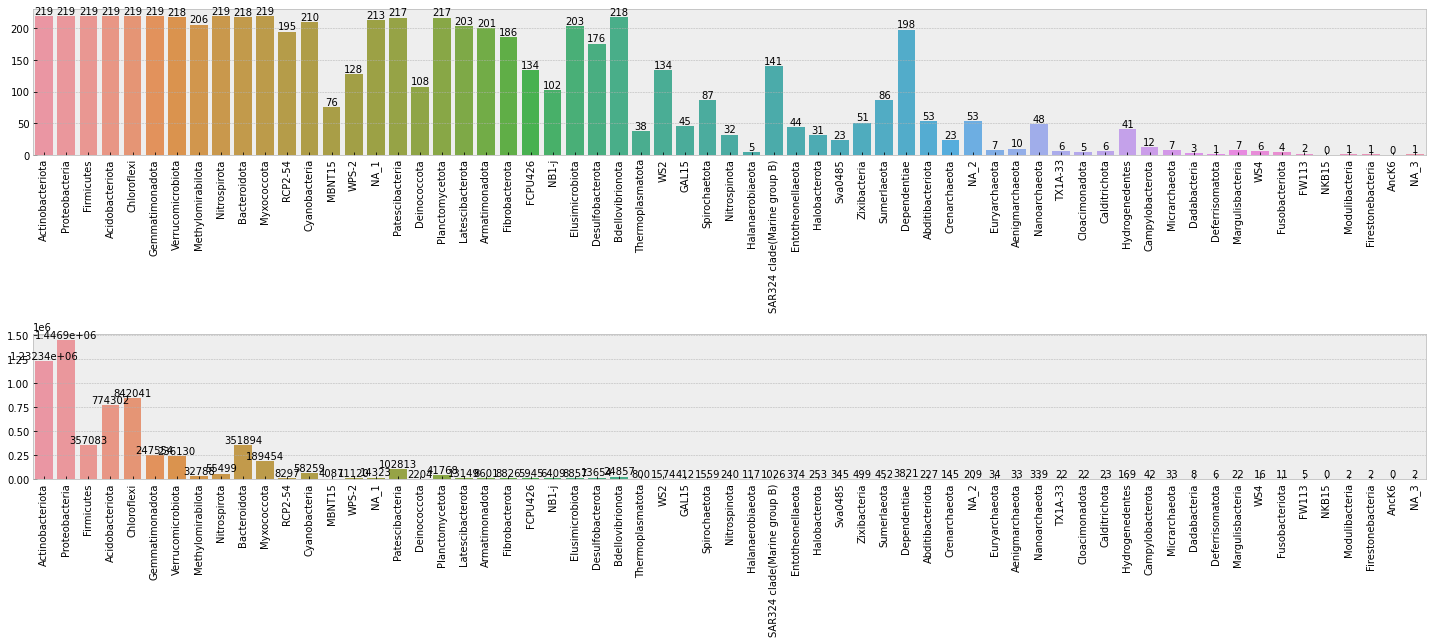

In [17]:
plt.figure(figsize=(20,9))
plt.subplot(2,1,1)
ax=sns.barplot(x=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns, y=nsample_OTU);
ax.bar_label(ax.containers[0]);
plt.xticks(rotation='vertical');
plt.subplot(2,1,2)
ax=sns.barplot(x=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns, y=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).sum(0));
ax.bar_label(ax.containers[0]);
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/Frequency.png',bbox_inches = 'tight',pad_inches=0)

In [18]:
fr_OTU=pd.DataFrame()
fr_OTU['OTU'] = data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns
fr_OTU['Fr']  = pd.DataFrame(nsample_OTU)
fr_OTU['value OTU']=data_original.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).sum(0).values
fr_OTU=fr_OTU.set_index('OTU')
fr_OTU=fr_OTU.sort_values('Fr',ascending=False)
fr_OTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/fr_OTU.csv', header=True)

# SET the threshold to remove OTU

In [19]:
th=15
remain_col=fr_OTU[fr_OTU['Fr']>th].index
remain_col=remain_col.insert(0, 'Link_ID')
CountOTU=data_original[remain_col]
CountOTU=CountOTU.set_index('Link_ID')
CountOTU.to_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/CountOTU.csv', header=True)
#data_C=pd.read_csv('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/DATA/CountOTU.csv', index_col=0)

In [20]:
CountOTU.shape

(219, 44)

In [21]:
CountOTU.head()

,Actinobacteriota,Myxococcota,Firmicutes,Acidobacteriota,Chloroflexi,Gemmatimonadota,Proteobacteria,Nitrospirota,Bdellovibrionota,Bacteroidota,...,Zixibacteria,Nanoarchaeota,GAL15,Entotheonellaeota,Hydrogenedentes,Thermoplasmatota,Nitrospinota,Halobacterota,Crenarchaeota,Sva0485
Link_ID,,,,,,,,,,,,,,,,,,,,,
MN_10_1_Y1,4466,925,495,2585,4111,541,5264,311,56,1473,...,11,0,17,0,0,0,0,0,0,0
MN_10_2_Y1,4666,953,472,2594,4350,587,5679,293,53,1373,...,11,0,8,9,3,0,0,2,0,0
MN_10_3_Y1,5757,943,506,3374,5744,742,6205,283,76,1391,...,2,0,18,0,0,0,0,0,0,8
MN_11_1_Y1,7060,1198,760,4247,6913,1052,8358,329,117,1864,...,4,18,14,0,6,0,0,7,0,0
MN_11_2_Y1,7393,1449,661,4426,7279,1167,8957,434,126,2341,...,9,0,16,22,0,0,0,5,5,18


# Data_after_filering

In [22]:
data = data_original[remain_col]
data['y_binary']=data_original['y_binary'].values
data['Yield_per_plant']=data_original ['Yield_per_plant'].values

/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_12347/1751268058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y_binary']=data_original['y_binary'].values
/var/folders/96/yh0jxgf16t5_3vj4pfcbh3ph0000gn/T/ipykernel_12347/1751268058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Yield_per_plant']=data_original ['Yield_per_plant'].values


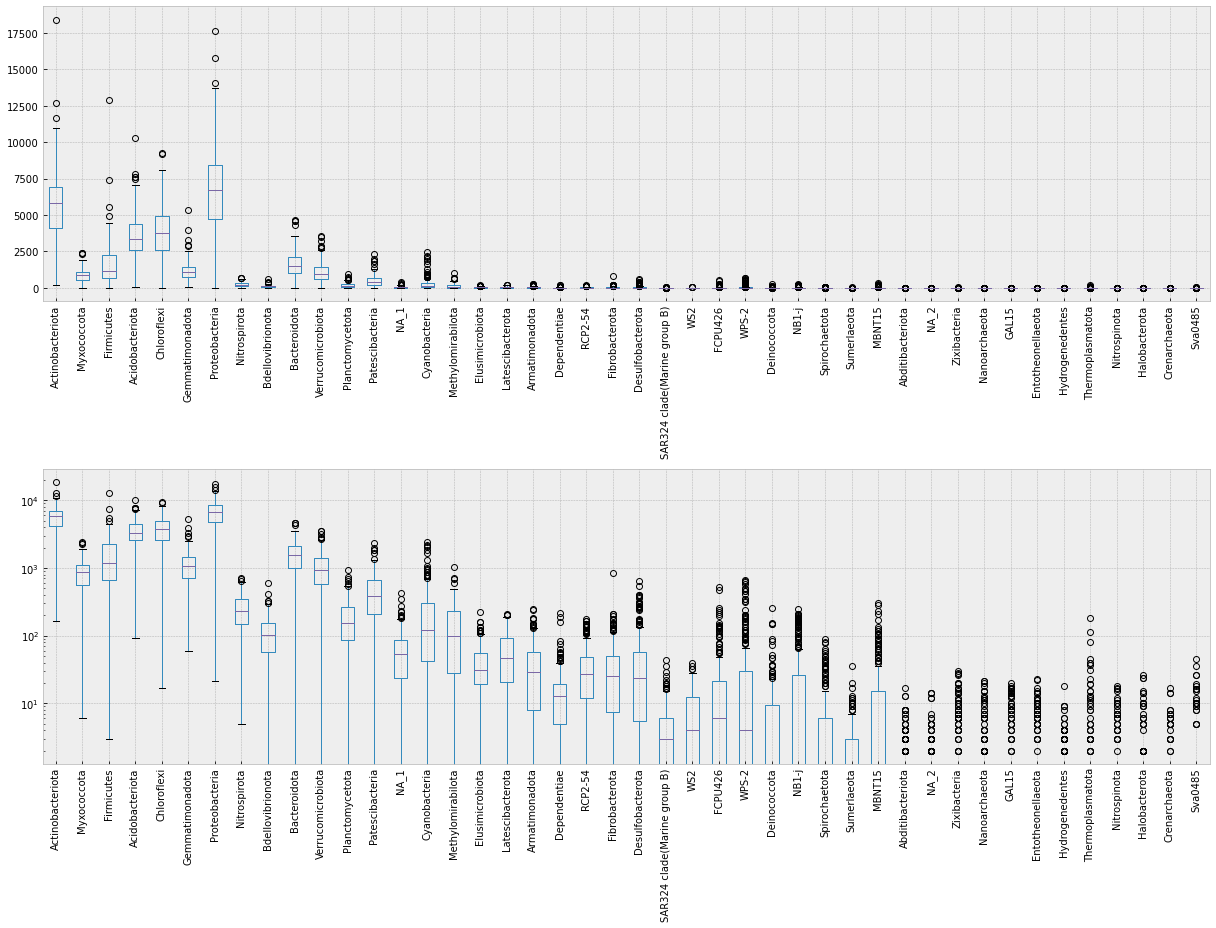

In [23]:
plt.figure(figsize=(17,13))
plt.subplot(2,1,1)
data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).boxplot()
plt.xticks(rotation='vertical');

plt.subplot(2,1,2)
data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).boxplot()
plt.semilogy()
plt.xticks(rotation='vertical');

plt.tight_layout()

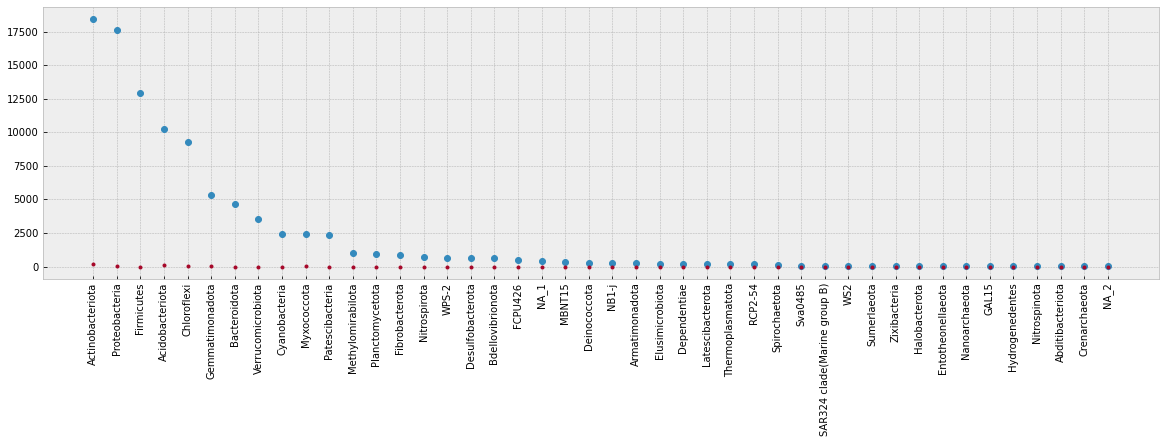

In [24]:
plt.figure(figsize=(20,5))
plt.plot(data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).max().sort_values(ascending=False),'o')
plt.plot(data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).min(),'.')
plt.xticks(rotation='vertical');
plt.show()

In [25]:
th=100
#th=0.05
important_features = data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).max().sort_values(ascending=False)[data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).max()>th].index
important_features = [item for item in important_features]
important_features.append('Yield_per_plant')
important_features.append('y_binary')

In [26]:
data_selected = data[important_features]

<AxesSubplot:>

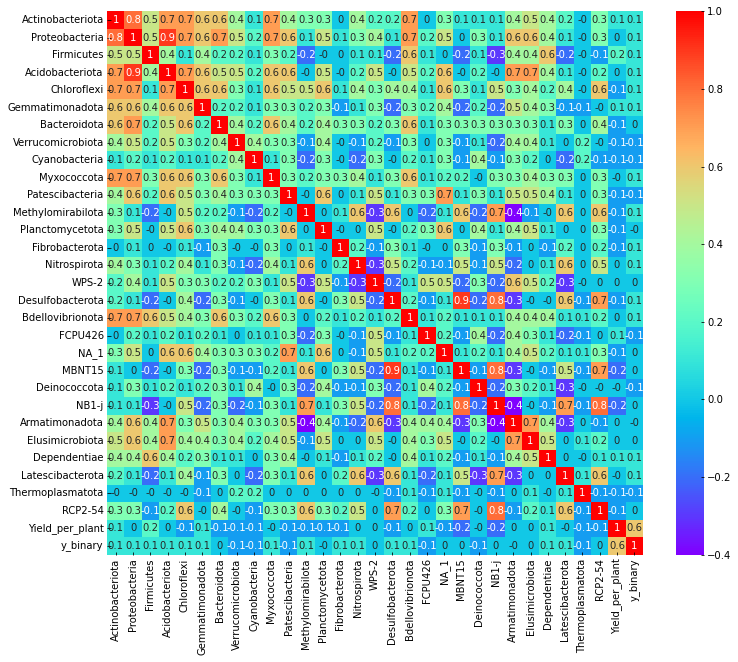

In [27]:
plt.figure(figsize=(12,10))
cor = data_selected.corr()
sns.heatmap(round(cor,1), annot=True, cmap="rainbow")

In [28]:
# sns.pairplot(data_selected,hue='Yield_per_plant')

In [29]:
x_column_list= data.drop(columns=['Link_ID', 'y_binary', 'Yield_per_plant']).columns

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(1,10):
        response = data['y_binary'].iloc[idx-1]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot1 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(10,20):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot2 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(20,30):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot3 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(30,40):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot4 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

tempList = []
for idx in range(0,data.shape[0]):
    for OTUNum in range(40,len(x_column_list)):
        response = data['y_binary'].iloc[idx]
        OTUName = data.columns[OTUNum]
        OTUValue = data[OTUName].iloc[idx]
        tempList.append([response,OTUName,OTUValue])

dataForBoxPlot5 = pd.DataFrame(tempList, columns=['response','OTUName','OTUValue'])

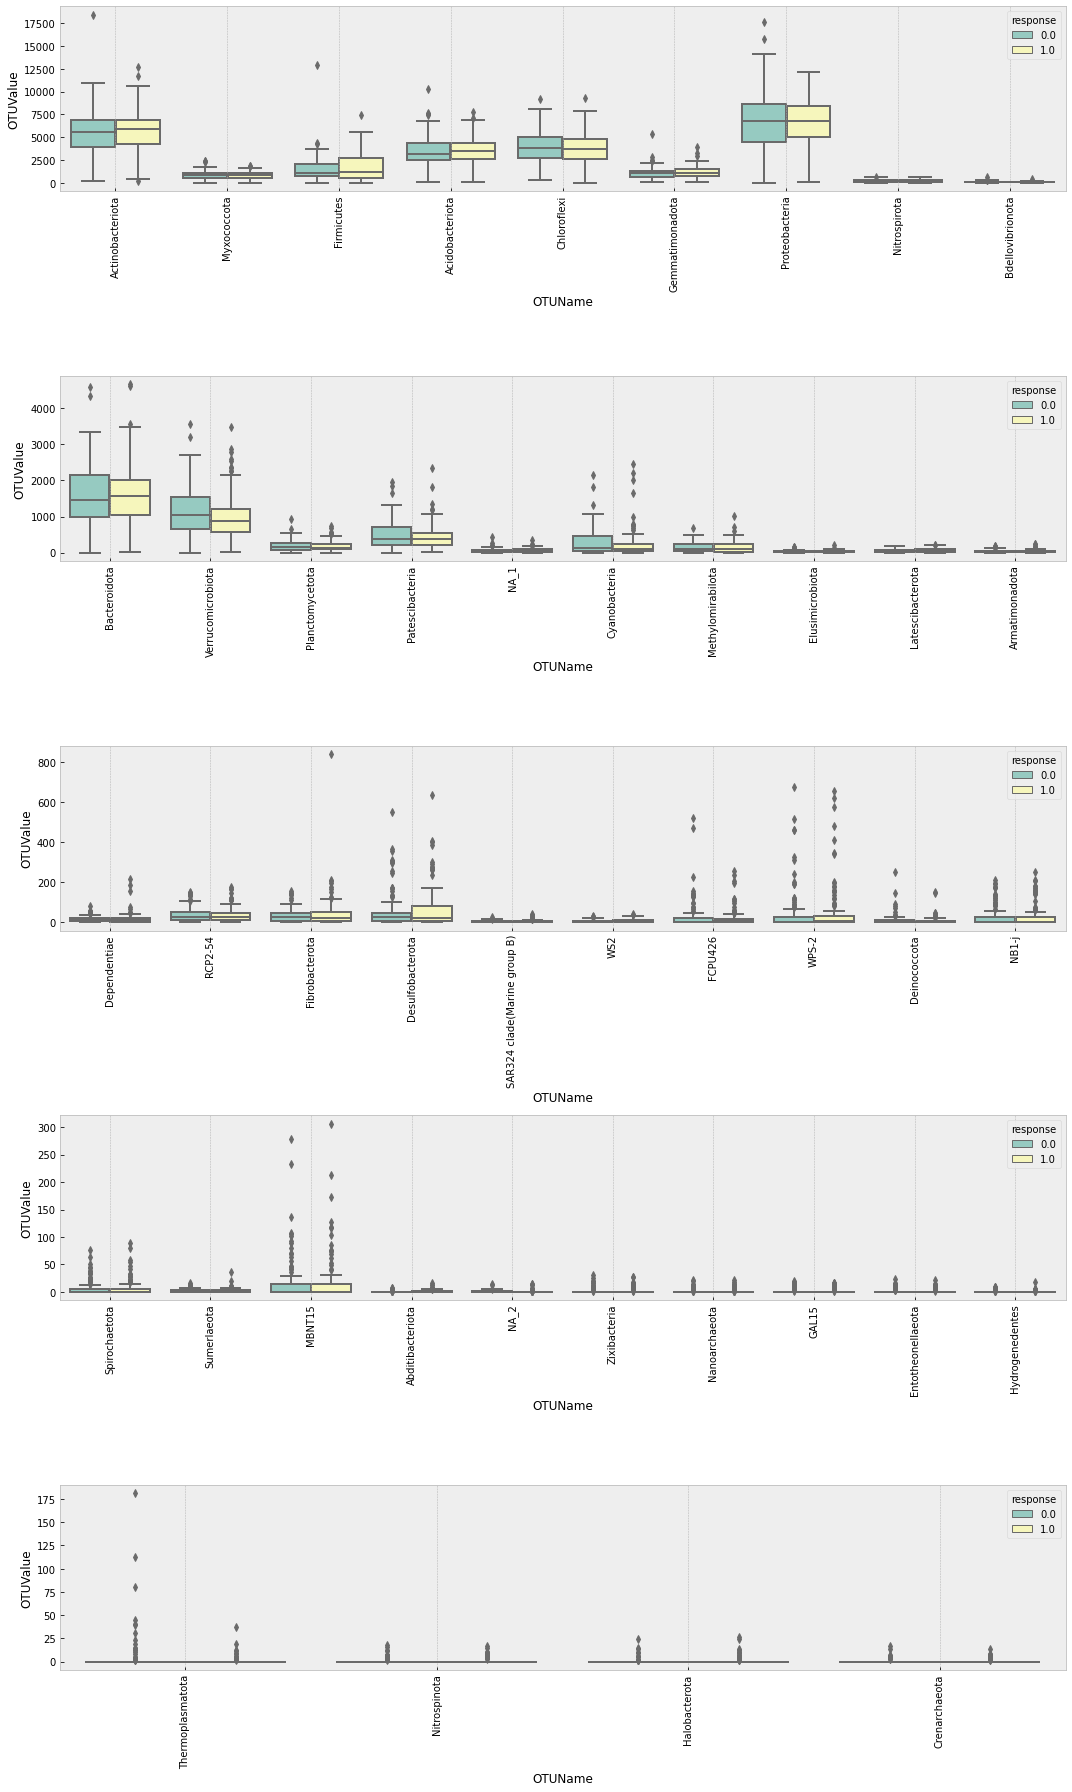

In [30]:
plt.figure(figsize=(15,25))
plt.subplot(5,1,1)
idx1 = dataForBoxPlot1['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot1, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,2)
idx1 = dataForBoxPlot2['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot2, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,3)
idx1 = dataForBoxPlot3['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot3, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,4)
idx1 = dataForBoxPlot4['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot4, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()

plt.subplot(5,1,5)
idx1 = dataForBoxPlot5['OTUName']
ax = sns.boxplot(x="OTUName", y="OTUValue", hue="response",data=dataForBoxPlot5, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.grid()
plt.tight_layout()
plt.savefig('/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Report/visualization/Box-plot.png',facecolor='white')



In [ ]:
# path1 = '/Users/rosa/Desktop/ALLWork/Madison/Project/Soil-nn/Code/pythoncode/Main Data Files/filter_data/'
# for file in os.listdir(path1):
#     if (file[0] == 'P')& (file[-4:] != '.csv'):
#         p=file
#         path = path1+p
#         os.chdir(path)
#         file_list = []
#         for file in os.listdir(path):
#             if (file[0] != 'R') & (file[-4:] == '.csv'):
#                 file_list.append(file) 
#         output_dic = dict.fromkeys(file_list)
#         for file in os.listdir(path):
#             if file[-4:] == '.csv':
#                 print(file)
#                 data_temp = pd.read_csv(file)
#                 output = process_data(response,data_temp,cv,q)
#                 output_dic[file] = [output[0],output[1], output[2],output[3]]
                
#         tRF=pd.DataFrame()
#         tALL=pd.DataFrame()
#         k=0
#         for key in output_dic.keys():
#             if key != '.csv':
#                 print(key)
#                 tRF[k]=pd.DataFrame(output_dic[key][3]['f1_RF'].values)
#                 tALL[k]=pd.DataFrame(output_dic[key][3]['f1_All'].values)
#                 k=k+1
#         tRF.index=output_dic[key][3].index
#         tALL.index=output_dic[key][3].index
#         tRF.to_csv('f1-score/result_f1_RF.csv')
#         tALL.to_csv('f1-score/result_f1_ALL.csv')